# BSSD5350 Midterm Project - Scott Bing

*Source Citation* https://towardsdatascience.com/building-a-machine-learning-classifier-model-for-diabetes-4fca624daed0<br>
*Source Citation* https://www.kaggle.com/atulnet/pima-diabetes-keras-implementation/notebook<br>

# Diabetes Notebook

This program builds a classifier for Pima Indians Diabetes dataset - https://www.kaggle.com/uciml/pima-indians-diabetes-database. It is a binary (2-class) classification problem. There are 768 observations with 8 input variables and 1 output/target variable. The variable names are as follows:

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)
- Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_cs

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

seed = 42
np.random.seed(seed)

pd.set_option('mode.chained_assignment', None)

In [3]:
# load Pima dataset
pdata = pd.read_csv('diabetes.csv')
pdata.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# take alook at the data sa whole
pdata.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
#check for NA (unknown) values
pdata.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
#drop any unknown values
pdata = pdata.dropna()

In [7]:
# Check for zero valued entries in each category

zero_fields = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def check_zero_entries(data, fields):
    """ List number of 0-entries in each of the given fields"""
    for field in fields:
        print('field %s: num 0-entries: %d' % (field, len(data.loc[ data[field] == 0, field ])))

check_zero_entries(pdata, zero_fields)

field Glucose: num 0-entries: 5
field BloodPressure: num 0-entries: 35
field SkinThickness: num 0-entries: 227
field Insulin: num 0-entries: 374
field BMI: num 0-entries: 11


In [8]:
# split the datset into train and test
from sklearn.model_selection import train_test_split

features = list(pdata.columns.values)
features.remove('Outcome')
print(features)
X = pdata[features]
y = pdata['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_test.shape)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
(576, 8)
(192, 8)


In [9]:
# lets fix the 0-entry for a field in the dataset with its mean value
# taken from:  https://www.kaggle.com/atulnet/pima-diabetes-keras-implementation/notebook
def impute_zero_field(data, field):
    nonzero_vals = data.loc[data[field] != 0, field]
    avg = np.sum(nonzero_vals) / len(nonzero_vals)
    k = len(data.loc[ data[field] == 0, field])   # num of 0-entries
    data.loc[ data[field] == 0, field ] = avg
    print('Field: %s; fixed %d entries with value: %.3f' % (field, k, avg))

In [10]:
# Fix it for Train dataset
for field in zero_fields:
    impute_zero_field(X_train, field)

Field: Glucose; fixed 4 entries with value: 122.003
Field: BloodPressure; fixed 25 entries with value: 72.846
Field: SkinThickness; fixed 163 entries with value: 29.465
Field: Insulin; fixed 270 entries with value: 158.464
Field: BMI; fixed 8 entries with value: 32.663


In [11]:
# double check for the Train dataset
check_zero_entries(X_train, zero_fields)

field Glucose: num 0-entries: 0
field BloodPressure: num 0-entries: 0
field SkinThickness: num 0-entries: 0
field Insulin: num 0-entries: 0
field BMI: num 0-entries: 0


In [12]:
# Fix for Test dataset
for field in zero_fields:
    impute_zero_field(X_test, field)

Field: Glucose; fixed 1 entries with value: 120.738
Field: BloodPressure; fixed 10 entries with value: 71.071
Field: SkinThickness; fixed 64 entries with value: 28.148
Field: Insulin; fixed 104 entries with value: 145.409
Field: BMI; fixed 3 entries with value: 31.841


In [13]:
# double check for the Test dataset
check_zero_entries(X_test, zero_fields)

field Glucose: num 0-entries: 0
field BloodPressure: num 0-entries: 0
field SkinThickness: num 0-entries: 0
field Insulin: num 0-entries: 0
field BMI: num 0-entries: 0


In [14]:
# Ensure that fieldnames aren't included
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

In [15]:
NB_EPOCHS = 1000  # num of epochs to test for
# for output brevit sake I do not print the result of 1000 epochs
# simply change verbose = 0 to verbose = 1 (below) to get epoch output details
BATCH_SIZE = 16

## Create our model
model = Sequential()

# 1st layer: input_dim=8, 12 nodes, RELU
model.add(Dense(12, input_dim=8, kernel_initializer='random_uniform', activation='relu'))
# 2nd layer: 8 nodes, RELU
model.add(Dense(8, kernel_initializer='random_uniform', activation='relu'))
# output layer: dim=1, activation sigmoid
model.add(Dense(1, kernel_initializer='random_uniform', activation='sigmoid' ))

# Compile the model
model.compile(loss='binary_crossentropy',   # since we are predicting 0/1
             optimizer='adam',
             metrics=['accuracy'])

# checkpoint: store the best model
ckpt_model = 'pima-weights.best.hdf5'
checkpoint = ModelCheckpoint(ckpt_model, 
                            monitor='val_accuracy',
                            verbose=0,
                            save_best_only=True,
                            mode='max')
callbacks_list = [checkpoint]

print('Starting training...')
# train the model, store the results for plotting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=NB_EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=0)

Starting training...


In [16]:
model.evaluate(X, y, verbose=2)

24/24 - 0s - loss: 0.6808 - accuracy: 0.7539


[0.6808304190635681, 0.75390625]

In [17]:
#you can copy the save and load from notebook 6.1
#but change theoutput filename
model.save("pima_diabetes")
#this created a 126.4 MB folder for me

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pima_diabetes\assets


In [18]:
import tensorflow as tf
from tensorflow import keras
#even though you load the model, you still have to load the data above
# and run the cells above tha define the vectorizer function, but
#you should not need to fit the model ever again
#once you get a good fit and save it.
model = tf.keras.models.load_model('pima_diabetes')

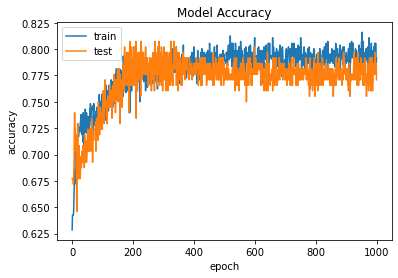

In [19]:
# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

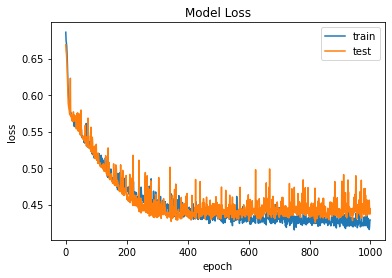

In [20]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [21]:
# print final accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 77.08%


In [22]:
# make probability predictions with the model
predictions = model.predict(X)
# round predictions 
rounded = [round(x[0]) for x in predictions]

In [23]:
# convert to nupy arrays for proper display
X = np.array(X)
y= np.array(y)

In [24]:
predictions = model.predict_classes(X)
# summarize the first 10 cases
for i in range(100):
	print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627, 50.0] => 0 (expected 1)
[1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351, 31.0] => 0 (expected 0)
[8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672, 32.0] => 0 (expected 1)
[1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167, 21.0] => 0 (expected 0)
[0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288, 33.0] => 1 (expected 1)
[5.0, 116.0, 74.0, 0.0, 0.0, 25.6, 0.201, 30.0] => 0 (expected 0)
[3.0, 78.0, 50.0, 32.0, 88.0, 31.0, 0.248, 26.0] => 0 (expected 1)
[10.0, 115.0, 0.0, 0.0, 0.0, 35.3, 0.134, 29.0] => 0 (expected 0)
[2.0, 197.0, 70.0, 45.0, 543.0, 30.5, 0.158, 53.0] => 1 (expected 1)
[8.0, 125.0, 96.0, 0.0, 0.0, 0.0, 0.232, 54.0] => 0 (expected 1

### Visually Compare Actual to Predicted

0    500
1    268
Name: Outcome, dtype: int64


Text(0.5, 1.0, 'Actual Diabetes Outcome')

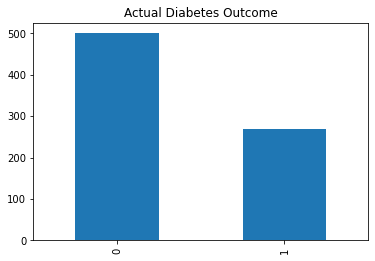

In [25]:
# Target class distribution is slightly imbalanced (see Appendix at the end of this notebook)
# '0'= no diabetes; '1'= diabetes
print(pdata.Outcome.value_counts())
pdata['Outcome'].value_counts().plot(kind='bar').set_title('Actual Diabetes Outcome')

0    627
1    141
dtype: int64


Text(0.5, 1.0, 'Predicited Diabetes Outcome')

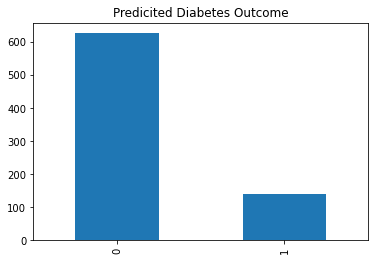

In [26]:
np.array(list(predictions)).shape
index =pd.Index(np.ndarray.flatten(predictions))
print(index.value_counts())
index.value_counts().plot(kind='bar').set_title('Predicited Diabetes Outcome')